## Matteo Esposito
### HW1 - Practical Report
#### University of Montreal/MILA

In [191]:
import numpy as np

######## DO NOT MODIFY THIS FUNCTION ########
def draw_rand_label(x, label_list):
    seed = abs(np.sum(x))
    while seed < 1:
        seed = 10 * seed
    seed = int(1000000 * seed)
    np.random.seed(seed)
    return np.random.choice(label_list)
#############################################

In [192]:
banknote = np.genfromtxt("data_banknote_authentication.txt", delimiter=",")

## Question 1

In [193]:
class Q1:
    def feature_means(self, banknote):
        avgs = []
        for i in range(banknote.shape[-1] - 1):
            avgs.append(np.average(banknote[:, i]))
        return avgs

    def covariance_matrix(self, banknote):
        return np.cov(banknote[:, :4], rowvar=False)

    def feature_means_class_1(self, banknote):
        return self.feature_means(banknote[banknote[:, 4] == 1])

    def covariance_matrix_class_1(self, banknote):
        return self.covariance_matrix(banknote[banknote[:, 4] == 1])

## Question 2

In [194]:
class HardParzen:
    def __init__(self, h):
        self.h = h

    def train(self, train_inputs, train_labels):
        self.train_inputs = train_inputs
        self.train_labels = train_labels
        self.label_list = np.unique(train_labels)

    def compute_predictions(self, test_data):
        num_test = test_data.shape[0]
        counts = np.ones((num_test, len(self.label_list)))
        classes_pred = np.zeros(num_test)

        for obs_index, observation in enumerate(test_data):
            # Get distance from point ex and every training example.
            euclidean_distances = np.sqrt(
                np.sum((self.train_inputs - observation) ** 2, axis=1)
            )

            # Get an array of all the points that are within the parzen window of the example point.
            neighbour_indices = euclidean_distances <= self.h

            for category_index, category in enumerate(self.label_list):
                counts[obs_index, category_index] = sum(
                    self.train_labels[neighbour_indices] == category
                )

            # If there are no points in the window, draw randomly, otherwise perform a vote.
            if np.sum(counts[obs_index, :]) == 0:
                classes_pred[obs_index] = int(
                    draw_rand_label(observation, self.label_list)
                )
            else:
                classes_pred[obs_index] = int(
                    self.label_list[np.argmax(counts[obs_index, :])]
                )

        return classes_pred

## Question 3

In [199]:
class SoftRBFParzen:
    def __init__(self, sigma):
        self.sigma = sigma

    def train(self, train_inputs, train_labels):
        self.train_inputs = train_inputs
        self.train_labels = train_labels
        self.label_list = np.unique(train_labels)

    def compute_predictions(self, test_data):
        num_test = test_data.shape[0]
        counts = np.zeros((num_test, len(self.label_list)))
        classes_pred = np.zeros(num_test)

        for obs_index, observation in enumerate(test_data):
            # Get distance from point observation and every training example.
            euclidean_distances = np.sqrt(
                np.sum((self.train_inputs - observation) ** 2, axis=1)
            )
            sumk = (
                1
                / (
                    ((2 * np.pi) ** (self.train_inputs.shape[1] / 2))
                    * (self.sigma ** ((self.train_inputs.shape[1])))
                )
            ) * np.exp(-0.5 * ((euclidean_distances ** 2) / (self.sigma ** 2)))

            for category_index, category in enumerate(self.label_list):
                counts[obs_index, category_index] = sum(
                    sumk[self.train_labels == category]
                )

            classes_pred[obs_index] = self.label_list[np.argmax(counts[obs_index, :])]

        return classes_pred

## Question 4

In [196]:
def split_dataset(banknote):
    train = banknote[[i for i in range(banknote.shape[0]) if i % 5 <= 2]]
    validation = banknote[[i for i in range(banknote.shape[0]) if i % 5 == 3]]
    test = banknote[[i for i in range(banknote.shape[0]) if i % 5 == 4]]
    return (train, validation, test)

## Question 5

In [197]:
class ErrorRate:
    def __init__(self, x_train, y_train, x_val, y_val):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val

    def hard_parzen(self, h):
        HP = HardParzen(h)
        HP.train(train_inputs=self.x_train, train_labels=self.y_train)
        preds = HP.compute_predictions(test_data=self.x_val)
        return preds[preds != self.y_val].shape[0] / preds.shape[0]

    def soft_parzen(self, sigma):
        SP = SoftRBFParzen(sigma)
        SP.train(train_inputs=self.x_train, train_labels=self.y_train)
        preds = SP.compute_predictions(test_data=self.x_val)
        return preds[preds != self.y_val].shape[0] / preds.shape[0]

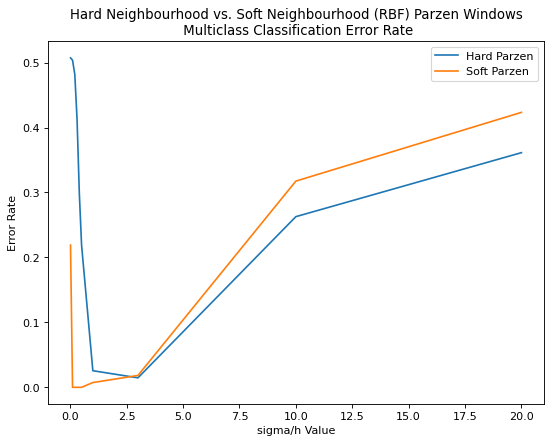

In [202]:
# Prep data
train, validation, test = split_dataset(banknote)

# Create ErrorRate object
ER = ErrorRate(x_train=train[:, :4], y_train=train[:, 4], x_val=validation[:, :4], y_val=validation[:, 4])

params = [0.01,0.1,0.2,0.3,0.4,0.5,1.0,3.0,10.0,20.0]
y1 = []
y2 = []
for p in params:
    y1.append(ER.hard_parzen(h=p))
    y2.append(ER.soft_parzen(sigma=p))
    
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(params, y1, label="Hard Parzen")
plt.plot(params, y2, label="Soft Parzen")
plt.plot()

plt.xlabel("sigma/h Value")
plt.ylabel("Error Rate")
plt.title("Hard Neighbourhood vs. Soft Neighbourhood (RBF) Parzen Windows\n Multiclass Classification Error Rate")
plt.legend()
plt.show()

Overall, the soft parzen implementation is the better performer since it has the lowest test error rate over the range of the sigma and h values considered. At very small values of sigma and h, we have a large error rate and this is a clear demonstration of overfitting. This is also the case in large values of sigma and h, which is expected and is a display of underfitting.

## Question 6

In [130]:
def get_test_errors(banknote):
    train, val, test = split_dataset(banknote)
    ER = ErrorRate(
        x_train=train[:, :4], x_val=val[:, :4], y_train=train[:, 4], y_val=val[:, 4]
    )

    # Get Errors
    params = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0]
    hard_errors = []
    soft_errors = []
    for p in params:
        hard_errors.append(ER.hard_parzen(h=p))
        soft_errors.append(ER.soft_parzen(sigma=p))

    # Get h* and sigma*
    hstar = params[np.argmin(hard_errors)]
    sigmastar = params[np.argmin(soft_errors)]

    # Get and return test error
    ERnew = ErrorRate(
        x_train=train[:, :4], x_val=test[:, :4], y_train=train[:, 4], y_val=test[:, 4]
    )
    v1 = ERnew.hard_parzen(h=hstar)
    v2 = ERnew.soft_parzen(sigma=sigmastar)

    return np.array([v1, v2])

## Question 7

Since we do not perform any operations besides assigning variables in our train() methods, its time complexity is O(1). In both compute_predictions() methods, our time complexity is O(MN) where N is the number of observations in our test_data and M is the number of training points we have. We perform a distance calculation for each point in the test set against each point in the training set and therefore this operation will contributes O(MN) to our time complexity. We take a maximum over all of the weights calculated which does also contribute to the time complexity of our algorithm but not in a more significant way than our previous operation.

These time complexities are independent of the values of h and sigma. We will always have to find the distance between each test point and all training points and then find the maximum of all sums of weights to determine the category that each test point will fall into.

## Question 8

In [171]:
def random_projections(X, A):
    return (1 / np.sqrt(2)) * np.matmul(X, A)

## Question 9

In [170]:
# Setup
num_samples = 500
params = [0.01,0.1,0.2,0.3,0.4,0.5,1.0,3.0,10.0,20.0]
hard_errors = np.zeros(shape=(num_samples, len(params)))
soft_errors = np.zeros(shape=(num_samples, len(params)))
projections = []
for i in range(num_samples):
    projections.append(np.random.normal(0, 1, (4, 2)))

train, valid, _ = split_dataset(banknote)
x_train = train[:, :4]
y_train = train[:, 4]
x_val = valid[:, :4]
y_val = valid[:, 4]

# Get Errors
for proj_index, proj in enumerate(projections):
    
    proj_train = random_projections(x_train, proj)
    proj_val = random_projections(x_val, proj)
    ER = ErrorRate(
        x_train=proj_train, y_train=y_train, x_val=proj_val, y_val=y_val
    )
    for p_index, p in enumerate(params):
        hard_errors[proj_index, p_index] = ER.hard_parzen(h=p)
        soft_errors[proj_index, p_index] = ER.soft_parzen(sigma=p)

hard_means = np.mean(hard_errors, axis=0)
soft_means = np.mean(soft_errors, axis=0)

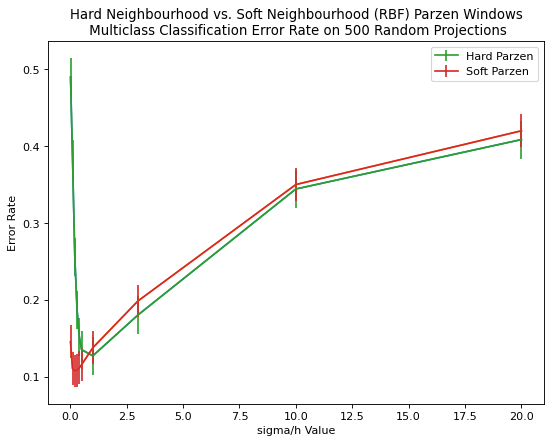

In [190]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(params, hard_means)
plt.plot(params, soft_means)
plt.errorbar(params, hard_means, yerr=0.2*np.std(hard_means), label="Hard Parzen")
plt.errorbar(params, soft_means, yerr=0.2*np.std(soft_means), label="Soft Parzen")

plt.xlabel("sigma/h Value")
plt.ylabel("Error Rate")
plt.title("Hard Neighbourhood vs. Soft Neighbourhood (RBF) Parzen Windows\n Multiclass Classification Error Rate on 500 Random Projections")
plt.legend()
plt.show();

Generally, results here are slightly worse than those in the previous figure. The best performing sigma/h choice for the soft parzen approach in this scenario (including the error bars) is slightly below 0.1 whereas we had near perfect classification in the previous figure for the same configuration.